In [1]:
import sys
import pickle
from pprint import pprint
import time
import datetime

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
backend = provider.get_backend("ibmq_brooklyn")
device = provider.backend.ibmq_brooklyn
print(provider)
print(device)

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>
ibmq_brooklyn


In [3]:
sys.path.append("../../libs_bell/")
from lib_graph_states import adjacency_list_for_path_graph, list_to_matrix, connection_graph_state

In [4]:
import qiskit
from qiskit import QuantumCircuit, Aer, execute

In [5]:
edges_order = [[[0,1],[2,3],[4,5],[6,7],[8,9],[10,13],[11,17],[12,21],[14,15],[18,19],[22,23],[24,29],[25,33],[26,37],[27,28],[30,31],[35,40],[38,41],[39,45],[42,43],[49,50],[47,53],[51,54],[52,56],[57,58],[59,60],[61,62],[63,64]],
               [[0,10],[1,2],[3,4],[5,6],[7,8],[13,14],[15,16],[17,18],[19,20],[21,22],[23,26],[27,38],[29,30],[31,39],[32,33],[34,35],[36,37],[41,42],[43,52],[44,45],[46,47],[48,49],[50,51],[54,64],[56,57],[58,59],[60,61],[62,63]],
               [[4,11],[8,12],[15,24],[16,17],[19,25],[20,21],[28,29],[31,32],[33,34],[35,36],[40,49],[43,44],[45,46],[47,48],[53,60],[55,56]]]

In [6]:
def adjacency_list(size, edges):
    adj_list = [[] for _ in range(size)]
    for i, j in edges:
        adj_list[i].append(j)
        adj_list[j].append(i)
    return adj_list

In [7]:
def flatten(list_of_list, level=1):
    ret_list = []
    for sub_list in list_of_list:
        if level > 1:
            sub_list = flatten(sub_list, level=level-1)
        ret_list += sub_list
    return ret_list

In [8]:
size = 65
vertex_list = list(range(size))
initial_layout = vertex_list # initial_layouts
Fs = [[3,6,9,10,17,21,24,25,26,31,35,38,44,47,54,56,59,62]] # subsets of focused vertices of graph size 1 to size
adj_lists = [adjacency_list(size, flatten(edges_order))] # adjacency list of graph size 1 to size
shots = 1 << 13 # shots per one execution

print("size:", size)
print("shots:", shots)
print("Fs:", Fs)
print("size of F:", len(Fs[0]))

size: 65
shots: 8192
Fs: [[3, 6, 9, 10, 17, 21, 24, 25, 26, 31, 35, 38, 44, 47, 54, 56, 59, 62]]
size of F: 18


In [9]:
from lib_connection_graphs import prepare_connection_graph_qcs

In [23]:
qc = connection_graph_state(size, edges_order, barrier=True)

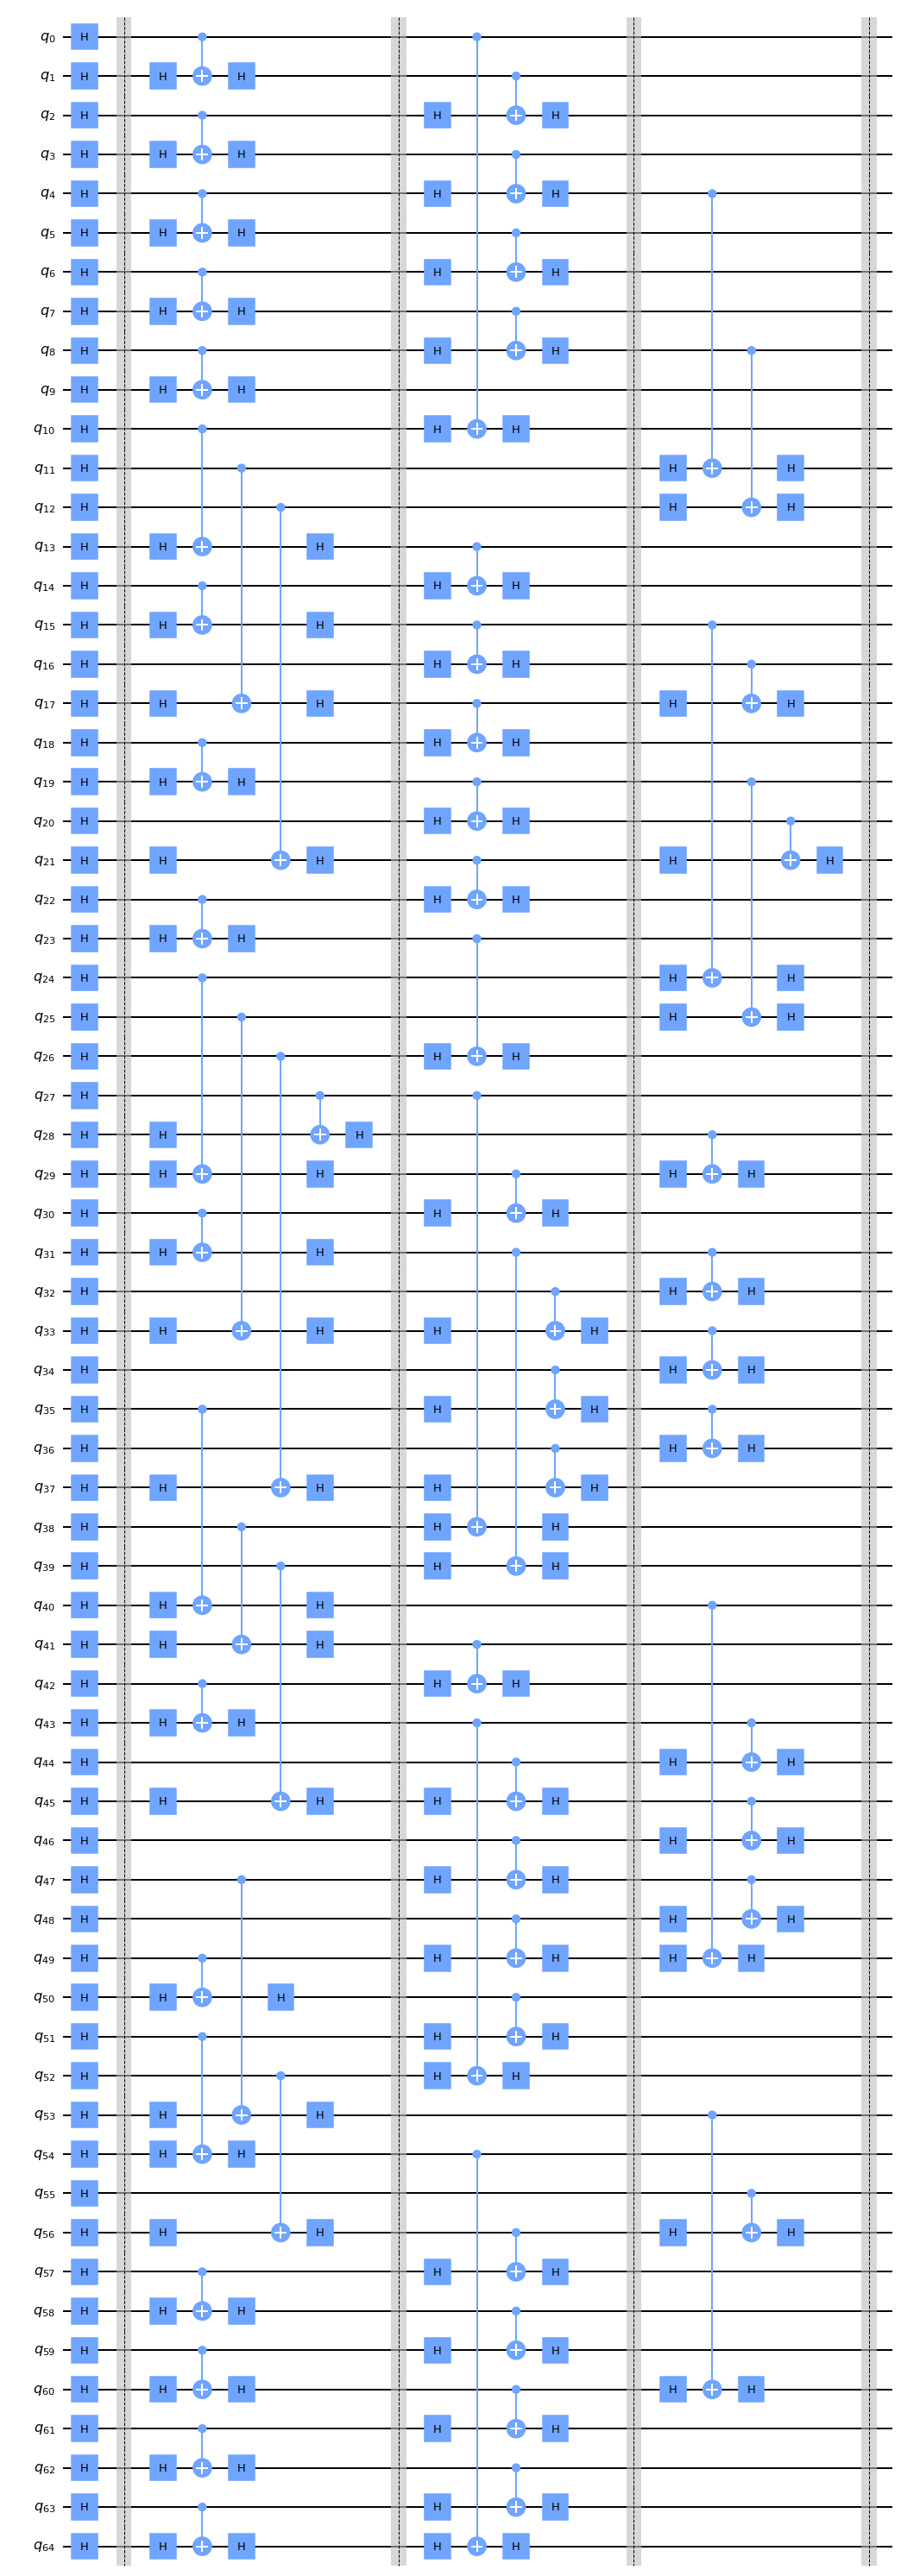

In [24]:
qc.draw("mpl")

In [12]:
base_type1 = [ 0,  2,  4,  6,  8, 
              13, 15, 17, 19, 21, 23,
              27, 29, 31, 33, 35, 37,
              41, 43, 45, 47, 49, 51,
              56, 58, 60, 62, 64]
base_type2 = [ 1,  3,  5,  7,  9,
              10, 11, 12,
              14, 16, 18, 20, 22,
              24, 25, 26,
              28, 30, 32, 34, 36,
              38, 39, 40,
              42, 44, 46, 48, 50,
              52, 53, 54,
              55, 57, 59, 61, 63]
assert len(base_type1) == len(set(base_type1))
assert len(base_type2) == len(set(base_type2))
assert len(base_type1 + base_type2) == len(set(base_type1 + base_type2))

In [13]:
qcs = prepare_connection_graph_qcs(qc, 
                                        base_type1, 
                                        base_type2, 
                                        backend = backend, 
                                        optimization_level = 1, 
                                        initial_layout = initial_layout)
print(len(qcs), "quantum circuits")

/Users/yangbo/opt/anaconda3/envs/qiskitenv/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


4 quantum circuits


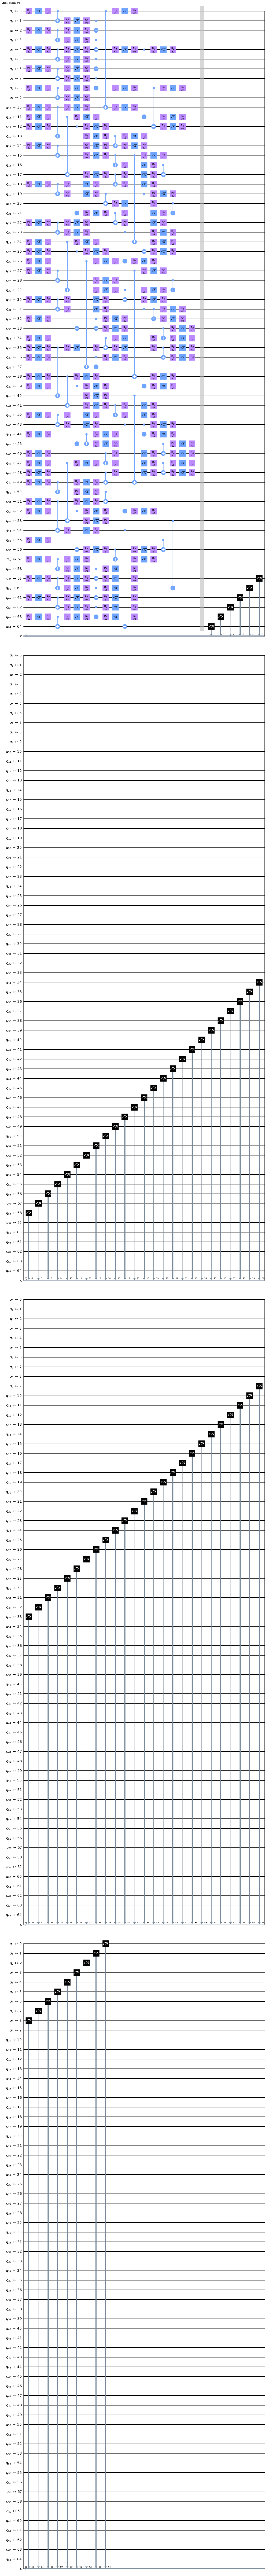

In [22]:
qcs[0].draw("mpl")

In [15]:
job = execute(qcs, backend = backend, shots=shots)
print(job.job_id())

61e342ab33a1eed2e2f17c83


In [16]:
dt_now = datetime.datetime.now()
job_id_filename = "job_id_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl"

In [17]:
with open("./pkls/" + job_id_filename, "wb") as f:
    pickle.dump(job.job_id(), f)

In [18]:
with open("./pkls/" + "properties_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl", "wb") as f:
    pickle.dump(device.properties(), f)

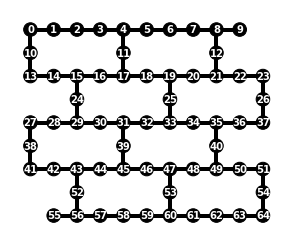

In [19]:
from qiskit.visualization import plot_circuit_layout
from qiskit import transpile
qc_on_device = transpile(qcs[-1], backend=backend, optimization_level=1, initial_layout=vertex_list)
plot_circuit_layout(qc_on_device, backend)

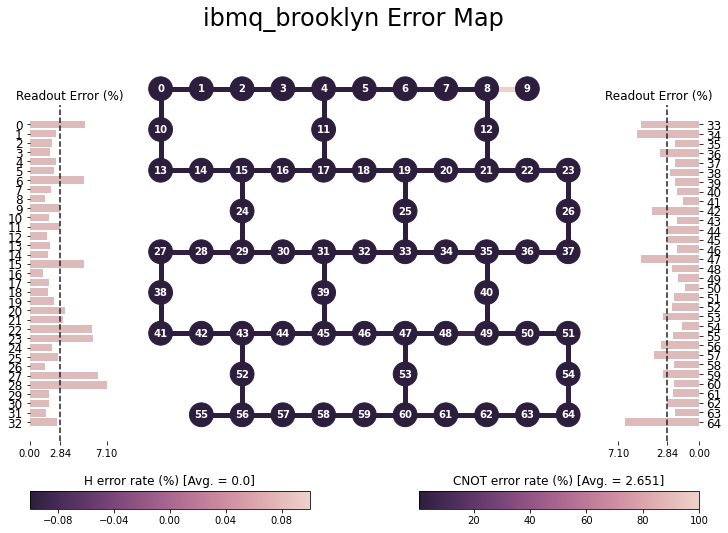

In [20]:
from qiskit.visualization import plot_error_map
plot_error_map(device)